In [6]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import cv2

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

import tensorflow as tf
from tensorflow import keras

In [2]:
df = pd.read_csv("../../data/metadata.csv")[["diagnostic", "img_id"]].rename({"diagnostic": "y", "img_id":"x_name"}, axis=1)
df

,y,x_name
0,NEV,PAT_1516_1765_530.png
1,BCC,PAT_46_881_939.png
2,ACK,PAT_1545_1867_547.png
3,ACK,PAT_1989_4061_934.png
4,BCC,PAT_684_1302_588.png
...,...,...
2293,ACK,PAT_1708_3156_175.png
2294,BCC,PAT_46_880_140.png
2295,SEK,PAT_1343_1217_404.png
2296,BCC,PAT_326_690_823.png


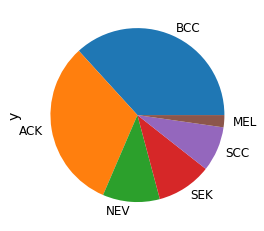

In [3]:
df["y"].value_counts().plot.pie();

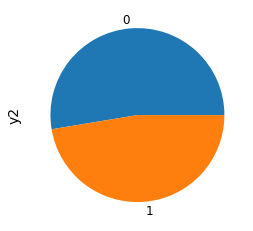

In [4]:
df["y2"] = df["y"].apply(lambda x:1 if x in ["MEL", "BCC", "SCC"] else 0) #Separate Cancer from Not-Cancer
df["y2"].value_counts().plot.pie();

In [7]:
def process_image(filename: str) -> np.ndarray:
    '''
    Placeholder fucntion to process images, currently only reads from file.
    '''
    return cv2.imread("../../data/images/"+filename)

df["x"] = df["x_name"].apply(process_image)

In [9]:
X = df["x"]
Y = df["y"]
Y_binary = df["y2"]